[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/sub-graph.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239937-lesson-2-sub-graphs)

# Sub-graphs

## Review

We're building up to a multi-agent research assistant that ties together all of the modules from this course.

We just covered parallelization, which is one important LangGraph controllability topic.

## Goals

Now, we're [going to cover sub-graphs](https://docs.langchain.com/oss/python/langgraph/use-subgraphs).

## State

Sub-graphs allow you to create and manage different states in different parts of your graph. 

This is particularly useful for multi-agent systems, with teams of agents that each have their own state.

Let's consider a toy example:

* I have a system that accepts logs
* It performs two separate sub-tasks by different agents (summarize logs, find failure modes)
* I want to perform these two operations in two different sub-graphs.

The most critical thing to understand is how the graphs communicate! 

In short, communication is **done with over-lapping keys**: 

* The sub-graphs can access `docs` from the parent
* The parent can access `summary/failure_report` from the sub-graphs

![subgraph.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb1abf89f2d847ee6f1ff_sub-graph1.png)

## Input

Let's define a schema for the logs that will be input to our graph.

In [ ]:
%%capture --no-stderr
%pip install -U  langgraph

We'll use [LangSmith](https://docs.langchain.com/langsmith/home) for [tracing](https://docs.langchain.com/langsmith/observability-concepts).

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [1]:
from dotenv import load_dotenv
load_dotenv(dotenv_path="C:/Users/riyaa/Documents/code/mat496/langgraphmod4/studio/.env", override=True) #path to my env folder

True

In [2]:
from operator import add
from typing_extensions import TypedDict
from typing import List, Optional, Annotated
from datetime import datetime
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash", 
    temperature=0.7,
)

# The structure of the book logs
class BookLog(TypedDict):
    id: str
    title: str
    genre: str
    checkout_date: str
    return_date: Optional[str]
    due_date: str
    user_id: str
    rating: Optional[int]
    late_fee: Optional[float]

## Sub graphs

Here is the failure analysis sub-graph, which uses `FailureAnalysisState`.

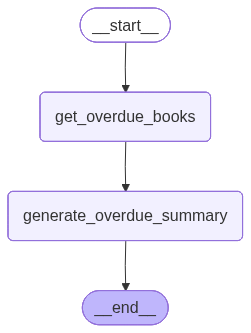

In [3]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Overdue Analysis Sub-graph
class OverdueAnalysisState(TypedDict):
    cleaned_logs: List[BookLog]
    overdue_books: List[BookLog]
    overdue_summary: str
    processed_logs: List[str]

class OverdueAnalysisOutputState(TypedDict):
    overdue_summary: str
    processed_logs: List[str]

def get_overdue_books(state):
    """ Get logs that contain overdue books """
    cleaned_logs = state["cleaned_logs"]
    overdue_books = [log for log in cleaned_logs if "late_fee" in log and log["late_fee"] is not None and log["late_fee"] > 0]
    return {"overdue_books": overdue_books}

def generate_overdue_summary(state):
    """ Generate summary of overdue books"""
    overdue_books = state["overdue_books"]
    
    overdue_data = "\n".join([
        f"- Book: {book['title']}, Genre: {book['genre']}, User: {book['user_id']}, Late Fee: ${book['late_fee']}, Due Date: {book['due_date']}"
        for book in overdue_books
    ])
    
    prompt = f"""Analyze the following overdue book data and provide a concise summary:

{overdue_data}

Please identify:
1. Which genres have the highest overdue rates
2. Any users with multiple overdue books
3. Average late fees and patterns
4. Key insights for the library management

Provide a brief, actionable summary."""

    
    response = llm.invoke([HumanMessage(content=prompt)])
    overdue_summary = response.content
    
    return {
        "overdue_summary": overdue_summary, 
        "processed_logs": [f"overdue-analysis-on-log-{book['id']}" for book in overdue_books]
    }

overdue_builder = StateGraph(state_schema=OverdueAnalysisState, output_schema=OverdueAnalysisOutputState)
overdue_builder.add_node("get_overdue_books", get_overdue_books)
overdue_builder.add_node("generate_overdue_summary", generate_overdue_summary)
overdue_builder.add_edge(START, "get_overdue_books")
overdue_builder.add_edge("get_overdue_books", "generate_overdue_summary")
overdue_builder.add_edge("generate_overdue_summary", END)
graph = overdue_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

Here is the question summarization sub-grap, which uses `QuestionSummarizationState`.

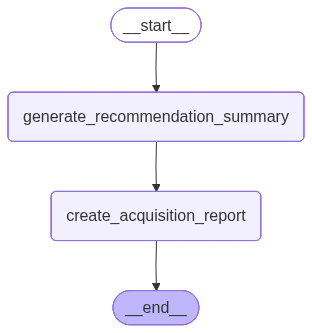

In [4]:
# Popular Books Recommendation Sub-graph
class RecommendationState(TypedDict):
    cleaned_logs: List[BookLog]
    recommendation_summary: str
    report: str
    processed_logs: List[str]

class RecommendationOutputState(TypedDict):
    report: str
    processed_logs: List[str]

def generate_recommendation_summary(state):
    """ Generate summary of popular books using LLM """
    cleaned_logs = state["cleaned_logs"]
    
    book_data = "\n".join([
        f"- Book: {log['title']}, Genre: {log['genre']}, Rating: {log.get('rating', 'N/A')}/5, User: {log['user_id']}"
        for log in cleaned_logs
    ])
    
    # Create prompt for LLM
    prompt = f"""Analyze the following library checkout and rating data:

{book_data}

Please identify:
1. Most popular genres
2. Highest rated books
3. Trending patterns
4. User preferences

Provide a concise summary of the analysis."""

    response = llm.invoke([HumanMessage(content=prompt)])
    summary = response.content
    
    return {
        "recommendation_summary": summary, 
        "processed_logs": [f"recommendation-on-log-{log['id']}" for log in cleaned_logs]
    }

def create_acquisition_report(state):
    """ Create acquisition recommendations using LLM """
    recommendation_summary = state["recommendation_summary"]
    
    prompt = f"""Based on the following library analysis:

{recommendation_summary}

Generate specific, actionable acquisition recommendations for the library. Include:
1. How many books to acquire in each genre
2. Specific themes or topics to focus on
3. Budget allocation suggestions
4. Timeline for acquisitions

Provide a clear, structured recommendation report."""

    # Get LLM response
    response = llm.invoke([HumanMessage(content=prompt)])
    report = response.content
    
    return {"report": report}

rec_builder = StateGraph(RecommendationState, output_schema=RecommendationOutputState)
rec_builder.add_node("generate_recommendation_summary", generate_recommendation_summary)
rec_builder.add_node("create_acquisition_report", create_acquisition_report)
rec_builder.add_edge(START, "generate_recommendation_summary")
rec_builder.add_edge("generate_recommendation_summary", "create_acquisition_report")
rec_builder.add_edge("create_acquisition_report", END)
graph = rec_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

## Adding sub graphs to our parent graph

Now, we can bring it all together.

We create our parent graph with `EntryGraphState`. 

And we add our sub-graphs as nodes! 

```
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())
```

In [5]:
# Entry Graph
class LibraryEntryGraphState(TypedDict):
    raw_logs: List[BookLog]
    cleaned_logs: List[BookLog]
    overdue_summary: str # This will only be generated in the Overdue Analysis sub-graph
    report: str # This will only be generated in the Recommendation sub-graph
    processed_logs: Annotated[List[str], add] # This will be generated in BOTH sub-graphs

But, why does `cleaned_logs` have a reducer if it only goes *into* each sub-graph as an input? It is not modified.

```
cleaned_logs: Annotated[List[Log], add] # This will be USED BY in BOTH sub-graphs
```

This is because the output state of the subgraphs will contain **all keys**, even if they are unmodified. 

The sub-graphs are run in parallel.

Because the parallel sub-graphs return the same key, it needs to have a reducer like `operator.add` to combine the incoming values from each sub-graph.

But, we can work around this by using another concept we talked about before.

We can simply create an output state schema for each sub-graph and ensure that the output state schema contains different keys to publish as output.

We don't actually need each sub-graph to output `cleaned_logs`.

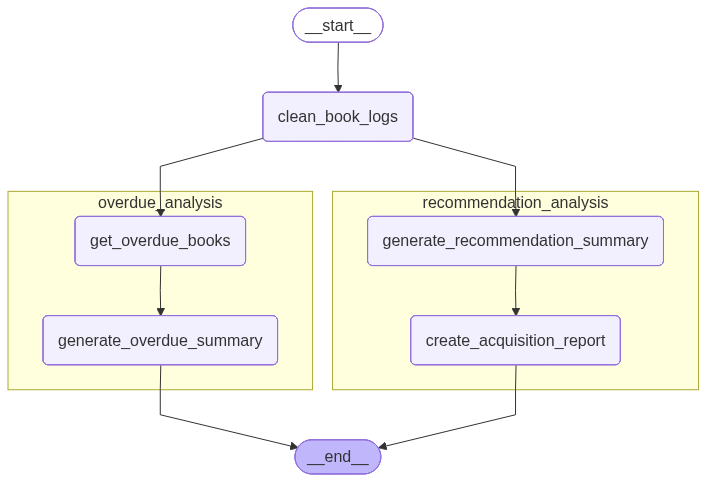

In [6]:
# Entry Graph
class LibraryEntryGraphState(TypedDict):
    raw_logs: List[BookLog]
    cleaned_logs: List[BookLog]
    overdue_summary: str # This will only be generated in the Overdue Analysis sub-graph
    report: str # This will only be generated in the Recommendation sub-graph
    processed_logs: Annotated[List[str], add] # This will be generated in BOTH sub-graphs

def clean_book_logs(state):
    # Get logs
    raw_logs = state["raw_logs"]
    # Data cleaning raw_logs -> cleaned book logs (validate dates, handle missing values, etc.)
    cleaned_logs = raw_logs
    return {"cleaned_logs": cleaned_logs}

library_entry_builder = StateGraph(LibraryEntryGraphState)
library_entry_builder.add_node("clean_book_logs", clean_book_logs)
library_entry_builder.add_node("recommendation_analysis", rec_builder.compile())
library_entry_builder.add_node("overdue_analysis", overdue_builder.compile())
library_entry_builder.add_edge(START, "clean_book_logs")
library_entry_builder.add_edge("clean_book_logs", "overdue_analysis")
library_entry_builder.add_edge("clean_book_logs", "recommendation_analysis")
library_entry_builder.add_edge("overdue_analysis", END)
library_entry_builder.add_edge("recommendation_analysis", END)
graph = library_entry_builder.compile()
from IPython.display import Image, display
# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [7]:
#Dummy logs
sample_book_logs = [
    {
        "id": "1",
        "title": "The Way of Kings",
        "genre": "Fantasy",
        "checkout_date": "2025-10-01",
        "return_date": "2025-10-20",
        "due_date": "2025-10-15",
        "user_id": "user_42",
        "rating": 5,
        "late_fee": 2.50
    },
    {
        "id": "2",
        "title": "Dune",
        "genre": "Science Fiction",
        "checkout_date": "2025-10-05",
        "return_date": "2025-10-12",
        "due_date": "2025-10-19",
        "user_id": "user_88",
        "rating": 5,
        "late_fee": None
    },
    {
        "id": "3",
        "title": "Pride and Prejudice",
        "genre": "Romance",
        "checkout_date": "2025-09-20",
        "return_date": "2025-10-10",
        "due_date": "2025-10-04",
        "user_id": "user_42",
        "rating": 4,
        "late_fee": 3.00
    },
    {
        "id": "4",
        "title": "1984",
        "genre": "Dystopian",
        "checkout_date": "2025-10-08",
        "return_date": "2025-10-15",
        "due_date": "2025-10-22",
        "user_id": "user_99",
        "rating": 5,
        "late_fee": None
    },
    {
        "id": "5",
        "title": "The Lies of Locke Lamora",
        "genre": "Fantasy",
        "checkout_date": "2025-09-25",
        "return_date": None,
        "due_date": "2025-10-09",
        "user_id": "user_42",
        "rating": None,
        "late_fee": 5.50
    },
    {
        "id": "6",
        "title": "Project Hail Mary",
        "genre": "Science Fiction",
        "checkout_date": "2025-10-10",
        "return_date": "2025-10-24",
        "due_date": "2025-10-24",
        "user_id": "user_101",
        "rating": 5,
        "late_fee": None
    },
    {
        "id": "7",
        "title": "The Final Empire",
        "genre": "Fantasy",
        "checkout_date": "2025-09-15",
        "return_date": "2025-10-05",
        "due_date": "2025-09-29",
        "user_id": "user_42",
        "rating": 4,
        "late_fee": 3.00
    }
]

# Run the graph
result = graph.invoke({"raw_logs": sample_book_logs})
print("\n")
print("=== LIBRARY MANAGEMENT ANALYSIS RESULTS  ===")
print( "\n")
print(" OVERDUE ANALYSIS SUMMARY:")
print("\n")
print(result["overdue_summary"])
print("\n")
print("ACQUISITION RECOMMENDATIONS REPORT:")
print("\n")
print(result["report"])
print("\n")
print("PROCESSED LOGS:")
for log in result["processed_logs"]:
    print(f"  ✓ {log}")
print("\n")



=== LIBRARY MANAGEMENT ANALYSIS RESULTS  ===


 OVERDUE ANALYSIS SUMMARY:


Here's a concise summary of the overdue book data:

**Summary:**

User user_42 has four overdue books: three Fantasy novels and one Romance novel. Fantasy appears to have a higher overdue rate based on this limited dataset. User_42 is the only user with multiple overdue items. Late fees range from $2.50 to $5.50. The average late fee is $3.50.

**Key Insights & Actionable Recommendations:**

*   **Focus on User_42:** Investigate why user_42 has multiple overdue books. Contact them to understand the reason for the late returns and potentially offer assistance or discuss borrowing habits.
*   **Monitor Fantasy Genre:** While the data is limited, the high proportion of overdue Fantasy books warrants monitoring. Consider promoting timely returns specifically for this genre.
*   **Evaluate Late Fee Structure:** The range of late fees is relatively narrow. While not a priority, consider whether the current fee stru

## LangSmith

Let's look at the LangSmith trace:

https://smith.langchain.com/public/f8f86f61-1b30-48cf-b055-3734dfceadf2/r